In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Galaxy Shape Demo

In [2]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolshoi', halo_finder='rockstar', redshift=0, version_name='halotools_v0p4')

In [5]:
from halotools.empirical_models import HodModelFactory

# define the central occupatoion model
from halotools.empirical_models import TrivialPhaseSpace, Cacciato09Cens
cens_occ_model =  Cacciato09Cens(prim_haloprop_key = 'halo_mvir', threshold = 9.0)
cens_prof_model = TrivialPhaseSpace()

# define the satellite occupation model
from halotools.empirical_models import Cacciato09Sats
from halotools.empirical_models import NFWPhaseSpace, SubhaloPhaseSpace
sats_occ_model =  Cacciato09Sats(prim_haloprop_key = 'halo_mvir', threshold = 9.0)
sats_occ_model._suppress_repeated_param_warning = True
sats_prof_model = NFWPhaseSpace()

# define quenching model
from halotools.empirical_models import ZuMandelbaum16QuenchingCens, ZuMandelbaum16QuenchingSats
cens_quenching_model = ZuMandelbaum16QuenchingCens(prim_haloprop_key = 'halo_mvir')
sats_quenching_model = ZuMandelbaum16QuenchingSats(prim_haloprop_key = 'halo_mvir')

# define shape model
from shape_model_componenets import PS08Shapes, EllipticalGalaxyShapes, DiskGalaxyShapes
cens_elliptical_shape_model = EllipticalGalaxyShapes(gal_type='centrals')
cens_disk_shape_model       = DiskGalaxyShapes(gal_type='centrals')
sats_elliptical_shape_model = EllipticalGalaxyShapes(gal_type='satellites')
sats_disk_shape_model       = DiskGalaxyShapes(gal_type='satellites')

# define alignment model
from intrinsic_alignments.ia_models.ia_model_components import RandomAlignment
central_orientation_model = RandomAlignment(gal_type='centrals')
satellite_orientation_model = RandomAlignment(gal_type='satellites')

# projected shapes
from shape_model_componenets import ProjectedShapes
central_proj_shapes_model = ProjectedShapes('centrals')
satellite_proj_shapes_model = ProjectedShapes('satellites')

# combine model components
model_instance = HodModelFactory(centrals_occupation = cens_occ_model,
                                 centrals_profile = cens_prof_model,
                                 satellites_occupation = sats_occ_model,
                                 satellites_profile = sats_prof_model,
                                 centrals_quenching = cens_quenching_model,
                                 satellites_quenching = sats_quenching_model,
                                 centrals_elliptical_galaxy_shape = cens_elliptical_shape_model,
                                 centrals_disk_galaxy_shape = cens_disk_shape_model,
                                 satellites_elliptical_galaxy_shape = sats_elliptical_shape_model,
                                 satellites_disk_galaxy_shape = sats_disk_shape_model,
                                 centrals_orientation = central_orientation_model,
                                 satellites_orientation = satellite_orientation_model,
                                 centrals_proj_shapes = central_proj_shapes_model,
                                 satellites_proj_shapes = satellite_proj_shapes_model,
                                 model_feature_calling_sequence = (
                                 'centrals_occupation',
                                 'centrals_profile',
                                 'satellites_occupation',
                                 'satellites_profile',
                                 'centrals_quenching',
                                 'satellites_quenching',
                                 'centrals_elliptical_galaxy_shape',
                                 'centrals_disk_galaxy_shape',
                                 'satellites_elliptical_galaxy_shape',
                                 'satellites_disk_galaxy_shape',
                                 'centrals_orientation',
                                 'satellites_orientation',
                                 'centrals_proj_shapes',
                                 'satellites_proj_shapes')
                                )

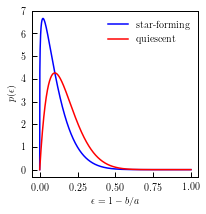

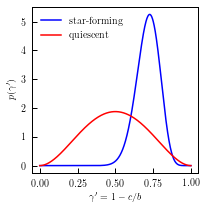

In [7]:
# examine shape distribution model

x = np.linspace(0,1,1000)
epsilon_1 = cens_disk_shape_model.epsilon_pdf(x)
gamma_prime_1 = cens_disk_shape_model.gamma_prime_pdf(x)
epsilon_2 = cens_elliptical_shape_model.epsilon_pdf(x)
gamma_prime_2 = cens_elliptical_shape_model.gamma_prime_pdf(x)



fig = plt.figure(figsize=(3.3,3.3))
rect = 0.2, 0.2, 0.7, 0.7  # left, bottom, width, height
ax = fig.add_axes(rect)
l1, = ax.plot(x, epsilon_1, color='blue')
l2, = ax.plot(x, epsilon_2, color='red')
ax.set_xlabel(r'$\epsilon = 1-b/a$')
ax.set_ylabel(r'$p(\epsilon)$')
plt.legend([l1,l2],['star-forming', 'quiescent'],
           frameon=False, numpoints=1, fontsize=10)
plt.show()

fig = plt.figure(figsize=(3.3,3.3))
rect = 0.2, 0.2, 0.7, 0.7  # left, bottom, width, height
ax = fig.add_axes(rect)
l1, = ax.plot(x, gamma_prime_1, color='blue')
l2, = ax.plot(x, gamma_prime_2, color='red')
ax.set_xlabel(r'$\gamma^{\prime} = 1-c/b$')
ax.set_ylabel(r'$p(\gamma^{\prime})$')
plt.legend([l1,l2],['star-forming', 'quiescent'],
           frameon=False, numpoints=1, fontsize=10)

plt.show()

## Populate Mock Catalog

In [9]:
# populate mock catalog
model_instance.populate_mock(halocat)
mock = model_instance.mock.galaxy_table

N_gal = len(mock)
print("number of galaxies: ", N_gal)

f_sat = 1.0*np.sum(mock['gal_type']=='satellites')/N_gal
print("satellite fraction: ", f_sat)

f_quiescent = 1.0*np.sum(mock['quiescent']==True)/N_gal
print("quiescent fraction: ", f_quiescent)

number of galaxies:  543025
satellite fraction:  0.272571244418
quiescent fraction:  0.521581879287


## 3D shape distribution

In [10]:
# calculate the distribution of shapes
bins = np.linspace(0,1,100)

# 3D axis ratios
counts_1 = np.histogram(mock['galaxy_b_to_a'], bins=bins)[0]
counts_2 = np.histogram(mock['galaxy_c_to_a'], bins=bins)[0]

# 2D elipticity
e = 1 - mock['galaxy_projected_b_to_a']
counts_3 = np.histogram(e, bins=bins)[0]
counts_3 = counts_3/np.sum(counts_3)/np.diff(bins)

mask_a = mock['quiescent']==True
ea = 1 - mock['galaxy_projected_b_to_a'][mask_a]
counts_3a = np.histogram(ea, bins=bins)[0]
counts_3a = counts_3a/np.sum(counts_3a)/np.diff(bins)

mask_b = mock['quiescent']==False
eb = 1 - mock['galaxy_projected_b_to_a'][mask_b]
counts_3b = np.histogram(eb, bins=bins)[0]
counts_3b = counts_3b/np.sum(counts_3b)/np.diff(bins)

fq = 1.0*np.sum(mask_a)/len(mock)

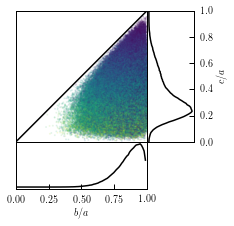

In [11]:
# 3D shape distribution
fig = plt.figure(figsize=(3.3,3.3))

# main panel
rect = 0.2-0.1, 0.35, 0.55, 0.55  # left, bottom, width, height
ax = fig.add_axes(rect)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.scatter(mock['galaxy_b_to_a'], mock['galaxy_c_to_a'],
           alpha=0.1, s=1, c=e, rasterized=True)
ax.plot([0,1],[0,1], '-', color='black')
ax.set_xlim([0,1])
ax.set_ylim([0,1])

# lower panel
rect = 0.2-0.1,0.15,0.55,0.2  # left, bottom, width, height
ax = fig.add_axes(rect)
ax.yaxis.set_visible(False)
ax.set_xlim([0,1])
ax.plot(bins[:-1], counts_1, color='black')
ax.set_xlabel(r'$b/a$')

# right panel
rect = 0.75-0.1,0.35,0.2,0.55  # left, bottom, width, height
ax = fig.add_axes(rect)
ax.xaxis.set_visible(False)
ax.set_ylim([0,1])
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.plot(counts_2, bins[:-1], color='black')
ax.set_ylabel(r'$c/a$')

plt.show()

## Projected Shape Distribution

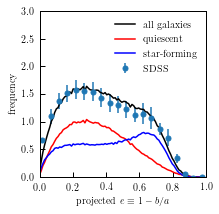

In [12]:
# observed ellipticity

# load PS08 data
from astropy.table import Table

# open elliptical data
t1 = Table.read('../data/PS08/figure_4.dat', format='ascii')
x1 = 1-t1['b/a']
y1 = t1['normalized_frequency']
err1 = np.fabs(t1['error_+'] - t1['error_-'])

# open disk data
t2 = Table.read('../data/PS08/figure_7.dat', format='ascii')
x2 = 1-t2['b/a']
y2 = t2['normalized_frequency']
err2 = np.fabs(t2['error_+'] - t2['error_-'])

# combine shape data into single sample, disks+ellipticals
f = 282203.0/(303390.0+282203.0)
y = (1-f)*y1 + f*y2
x = (x1+x2)/2.0
err = np.sqrt((1-f)*err1**2 + f*err2**2)

# 2D shape distribution
fig = plt.figure(figsize=(3.3,3.3))

# main panel
rect = 0.2, 0.2, 0.7, 0.7  # left, bottom, width, height
ax = fig.add_axes(rect)
l1, = ax.plot(bins[:-1], counts_3, color='black')
l2, = ax.plot(bins[:-1], counts_3a*fq, color='red')
l3, = ax.plot(bins[:-1], counts_3b*(1-fq), color='blue')
p1 = ax.errorbar(x, y, yerr=err, fmt='o', ms=5)
ax.set_xlim([0,1])
ax.set_ylim([0,3])
ax.set_xlabel(r'${\rm projected}~e \equiv 1 - b/a$')
ax.set_ylabel('frequency')
plt.legend([l1,l2,l3,p1],
           ['all galaxies', 'quiescent', 'star-forming', 'SDSS'],
           frameon=False, numpoints=1, fontsize=10)

plt.show()

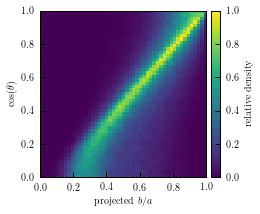

In [13]:
# inclination angle effect

x = 1-e
y = np.fabs(np.cos(mock['galaxy_theta']))

bins = np.linspace(0,1,50)
z = np.histogram2d(x, y, bins=bins)[0]
z = z/np.max(z)

# inclination angle
fig = plt.figure(figsize=(3.3,3.3))

# main panel
rect = 0.2, 0.2, 0.7, 0.7  # left, bottom, width, height
ax = fig.add_axes(rect)
rect = 0.92, 0.2, 0.04, 0.7  # left, bottom, width, height
cax = fig.add_axes(rect)
im = ax.imshow(z.T[::-1], interpolation='nearest', extent=[0,1,0,1])
ax.set_xlabel(r'${\rm projected}~ b/a$')
ax.set_ylabel(r'$\cos(\theta)$')
fig.colorbar(im,cax=cax, label='relative density')
plt.show()